In [55]:
import pandas
import matplotlib
import seaborn
import lifelines

from scipy.stats import mannwhitneyu
from cliffsDelta import cliffsDelta

%matplotlib inline

In [57]:
FIG_SIZE = (6, 2.5)

ECOSYSTEMS = ['Cargo', 'NPM', 'Packagist']
DATE_RANGE = pandas.to_datetime('2013-01-01'), pandas.to_datetime('2018-11-30')

PALETTE = seaborn.color_palette()
COLORS = {e: PALETTE[i] for i, e in enumerate(ECOSYSTEMS)}

SAVEFIG = False

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

def _savefig(fig, name):
    fig.savefig(
        os.path.join(FIGURE_PATH, '{}.pdf'.format(name)),
        bbox_inches='tight'
    )
    
savefig = _savefig if SAVEFIG else lambda x, y: None

## Dataset

### Load data

In [3]:
df_releases = dict()
df_dependencies = dict()

for ecosystem in ECOSYSTEMS:
    print('Loading', ecosystem)
    print('.. releases')
    df_releases[ecosystem] = (
        pandas.read_csv(
            '../data/{}-releases.csv.gz'.format(ecosystem),
            parse_dates=['date'],
            infer_datetime_format=True,
        )
        [lambda d: d['date'] >= pandas.to_datetime('1990-01-01')]
    )
    
    print('.. dependencies')
    df_dependencies[ecosystem] = (
        pandas.read_csv(
            '../data/{}-dependencies.csv.gz'.format(ecosystem),
        )
    )
print('Done!')

Loading Cargo
.. releases
.. dependencies
Loading NPM
.. releases
.. dependencies
Loading Packagist
.. releases
.. dependencies
Done!


### Dataset overview

In [4]:
data = pandas.DataFrame(index=['packages', 'releases', 'dependencies', 'first'], columns=ECOSYSTEMS)

for ecosystem in ECOSYSTEMS:
    data.at['packages', ecosystem] = len(df_releases[ecosystem].drop_duplicates(['package']))
    data.at['releases', ecosystem] = len(df_releases[ecosystem].drop_duplicates(['package', 'version']))
    data.at['dependencies', ecosystem] = len(df_dependencies[ecosystem])
    data.at['first', ecosystem] = df_releases[ecosystem]['date'].min()
    
data

,Cargo,NPM,Packagist
packages,20635,902455,142130
releases,113148,6027930,1090061
dependencies,432807,28364315,3080149
first,2014-11-11 00:22:07,2010-11-09 23:36:08,1994-08-23 00:00:00


## How prevalent are 0.y.z?

## Packages in 0.y.z

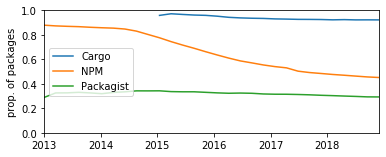

In [5]:
fig, ax = matplotlib.pyplot.subplots()

dates = pandas.date_range(*DATE_RANGE, periods=30)
data = dict()

for ecosystem in ECOSYSTEMS:
    data[ecosystem] = []
    
    _ = df_releases[ecosystem]
    for date in reversed(dates):
        _ = _[lambda d: d['date'] <= date]
        
        data[ecosystem].append((
            date, 
            _.package.nunique(),
            len(_.drop_duplicates('package', keep='last')[lambda d: d['major'] == 0]),
        ))
    
    (
        pandas.DataFrame(data[ecosystem], columns=['date', 'packages', 'zero'])
        .set_index('date')
        .sort_index()
        .assign(**{ecosystem: lambda d: d['zero'] / d['packages']})
        [[ecosystem]]
        .plot(ax=ax, color=COLORS[ecosystem])
    )
    
ax.set(
    xlabel='', 
    xlim=DATE_RANGE,
    ylabel='prop. of packages',
    ylim=(0, 1)
)
ax.legend(loc='center left')
fig.autofmt_xdate(bottom=0.2, rotation=0, ha='center')

savefig(fig, 'prevalence_packages')    

In [6]:
_ = pandas.concat([
    pandas.DataFrame(data[ecosystem], columns=['date', 'packages', 'zero'])
    .set_index('date')
    .eval('prop = zero / packages')
    .assign(ecosystem=ecosystem)
for ecosystem in ECOSYSTEMS], axis=0)

_.sort_index().iloc[-3:]

,packages,zero,prop,ecosystem
date,,,,
2018-11-30,885137,399866,0.451756,NPM
2018-11-30,140992,41312,0.293010,Packagist
2018-11-30,20038,18483,0.922397,Cargo


### Monthly proportion of 0.y.z updates

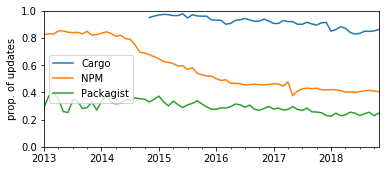

In [7]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_releases[ecosystem]
        .assign(dev=lambda d: d['major'] == 0)
        .groupby([pandas.Grouper(key='date', freq='M'), 'dev'])
        [['version']]
        .count()
        .unstack()['version']
        .assign(total=lambda d: d[True] + d[False])
        .assign(
            zero= lambda d: d[True] / d['total'],
            over= lambda d: d[False] / d['total'],
        )
    )
    
    data[ecosystem]['zero'].rename(ecosystem).plot(ax=ax, color=COLORS[ecosystem])

ax.legend()

ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='prop. of updates',
    ylim=(0, 1),
)

savefig(fig, 'prevalence_updates')

In [8]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .iloc[-1]
    .rename(ecosystem)
for ecosystem in ECOSYSTEMS], axis=1).loc[['zero', 'total']]

,Cargo,NPM,Packagist
dev,,,
zero,0.863387,0.40497,0.247996
total,4187,160123,13097


## How long does it take to reach 1.0.0?

a.k.a "The 1.0.0 barrier"

### Packages having reached the 1.0.0 barrier

### Time to reach 1.0.0

## How frequently are 0.y.z updated?

a.k.a "Major version zero is all about rapid development"

### Update delay before and after 1.0.0

In [48]:
data = pandas.concat([
    df_releases[ecosystem]
    #[lambda d: d['package'].isin(has_both[ecosystem])]
    .assign(when=lambda d: pandas.np.where(d['major'] == 0, 'before', 'after'))
    .groupby(['package', 'when'], sort=False)
    .agg(
        first=('date', 'min'),
        last=('date', 'max'),
        nb=('version', 'count'),
    )
    .reset_index()
    .assign(delay=lambda d: (d['last'] - d['first']).dt.days / d['nb'])
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'when', 'nb', 'delay']]
    for ecosystem in ECOSYSTEMS],
    axis=0
)

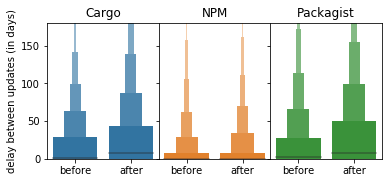

In [50]:
fig, axes = matplotlib.pyplot.subplots(
    ncols=len(ECOSYSTEMS), 
    sharex=False, 
    sharey=True,
    gridspec_kw=dict(wspace=0)
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    seaborn.boxenplot(
        y='delay',
        x='when',
        data=data[lambda d: d['ecosystem'] == ecosystem],
        order=['before', 'after'],
        color=COLORS[ecosystem],
        ax=axes[i],
    )
    
    axes[i].set(
        title=ecosystem,
        xlabel='', 
        ylabel=''
    )

axes[0].set(
    xlabel='',
    ylabel='delay between updates (in days)',
    ylim=(0, 180),
)

savefig(fig, 'rapid_update_delay')

In [51]:
(
    data
    .groupby(['ecosystem', 'when'])
    [['nb', 'delay']]
    .describe()
    .T
)

ecosystem          Cargo                          NPM                 \
when               after        before          after         before   
nb    count  1611.000000  19762.000000  496258.000000  482998.000000   
      mean      6.991930      5.155551       6.240647       6.068263   
      std      22.239226      8.344233      24.837607      14.312377   
      min       1.000000      1.000000       1.000000       1.000000   
      25%       1.000000      1.000000       1.000000       1.000000   
      50%       3.000000      2.000000       2.000000       3.000000   
      75%       6.000000      6.000000       6.000000       6.000000   
      max     321.000000    210.000000    5301.000000    1984.000000   
delay count  1611.000000  19762.000000  496258.000000  482998.000000   
      mean     34.459673     23.956707      14.603801      13.906545   
      std      61.351909     47.148410      40.788760      41.504820   
      min       0.000000      0.000000       0.000000       0.000000   
      25%       0.000000      0.000000       0.000000       0.000000   
      50%       8.000000      1.400000       0.000000       0.000000   
      75%      42.972826     29.500000       8.200000       7.800000   
      max     587.500000    609.000000    1225.500000    1176.000000   

ecosystem        Packagist                
when                 after        before  
nb    count  100524.000000  54570.000000  
      mean        7.774701      5.653601  
      std        20.018423      9.471260  
      min         1.000000      1.000000  
      25%         1.000000      1.000000  
      50%         3.000000      3.000000  
      75%         7.000000      6.000000  
      max      2316.000000    371.000000  
delay count  100524.000000  54570.000000  
      mean       39.447542     26.640892  
      std        71.903771     58.230580  
      min         0.000000      0.000000  
      25%         0.000000      0.000000  
      50%         8.160256      2.000000  
      75%        50.333333     27.032609  
      max      2713.333333    972.000000

Statistical comparisons based on Mann-Whitney U and Cliff's Delta:

In [49]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['when'] == 'before')].delay
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['when'] == 'after')].delay
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} before vs. after: p={:.5f}; |d|={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      before vs. after: p=0.00000; |d|=-0.120 (negligible)
NPM        before vs. after: p=0.00000; |d|=0.028 (negligible)
Packagist  before vs. after: p=0.00000; |d|=-0.116 (negligible)


## How permissive are pre-1.0.0 dependency constraints?

a.k.a. "Major version zero (0.y.z) is for initial development. Anything MAY change at any time."

### Permissiveness of pre-1.0.0 constraints

Only versions released during a month are considered for this month.

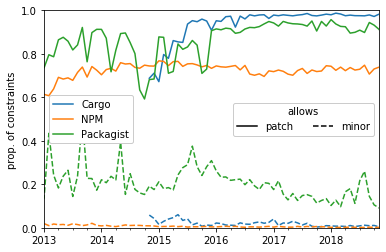

In [56]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_dependencies[ecosystem]
        [lambda d: d['i_dev'] == True]
        .merge(
            df_releases[ecosystem][['package', 'date', 'rank']],
            how='inner',
            left_on=['source', 'rank'],
            right_on=['package', 'rank'],
        )
        .groupby(pandas.Grouper(key='date', freq='M'))
        .agg({
            'constraint': 'count',
            'i_minor': 'sum',
            'i_patch': 'sum',
        })
        .eval('minor = i_minor / constraint')
        .eval('patch = i_patch / constraint')
    )
    
    data[ecosystem][['patch', 'minor']].plot(
        color=2 * [COLORS[ecosystem]], 
        style=['-', '--'],
        legend=False,
        ax=ax
    )

patch = lambda c, s: matplotlib.lines.Line2D([0], [0], color=c, linestyle=s)

legend = ax.legend(
    [patch(COLORS[ecosystem], '-') for ecosystem in ECOSYSTEMS],
    ECOSYSTEMS,
    loc='center left',
    framealpha=1,
)

ax.legend(
    [patch('k', '-'), patch('k', '--')],
    ['patch', 'minor'],
    loc='center right',
    title='allows',
    ncol=2,
    framealpha=1,
)

ax.add_artist(legend)

ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='prop. of constraints',
    ylim=(0, 1),
)

savefig(fig, 'stable_permissiviness')

In [30]:
_ = pandas.concat([
        data[ecosystem]
        .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS
    ], 
    axis=0
)

_.groupby('ecosystem')[['minor', 'patch']].describe().T

ecosystem        Cargo        NPM  Packagist
minor count  50.000000  97.000000  84.000000
      mean    0.019319   0.013894   0.187850
      std     0.013857   0.016603   0.108072
      min     0.003348   0.000000   0.000000
      25%     0.009698   0.004207   0.132726
      50%     0.014533   0.006678   0.181665
      75%     0.023139   0.015329   0.232959
      max     0.060491   0.069534   0.692308
patch count  50.000000  97.000000  84.000000
      mean    0.938449   0.659599   0.845788
      std     0.078535   0.149844   0.144753
      min     0.672106   0.000000   0.000000
      25%     0.949677   0.613568   0.814271
      50%     0.974620   0.721712   0.895667
      75%     0.978397   0.740271   0.924879
      max     0.987158   0.767887   1.000000

In [31]:
_.sort_index().iloc[-3:]

,constraint,i_minor,i_patch,minor,patch,ecosystem
date,,,,,,
2018-12-31,93629,419.0,68532.0,0.004475,0.731953,NPM
2018-12-31,11003,40.0,10649.0,0.003635,0.967827,Cargo
2018-12-31,1489,150.0,1319.0,0.100739,0.885829,Packagist


## To what extent are 0.y.z packages used by other packages?

a.k.a. "If your software is being used in production, it should probably already be 1.0.0. If you have a stable API on which users have come to depend, you should be 1.0.0."

### Number of dependents for packages above and below 1.0.0

Only the latest snapshot of each ecosystem is considered.

### Packages relying on <1.0.0

Both for all packages, and production packages (i.e. >=1.0.0).

**note**: only packages being released during a month are considered for this month.

### (REMOVE) Packages >=1.0.0 relying on <1.0.0

**note**: only packages being released during a month are considered for this month.

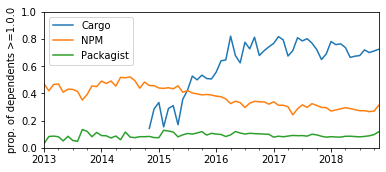

In [24]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_releases[ecosystem]
        [lambda d: d['major'] > 0]
        .merge(
            (
                df_dependencies[ecosystem]
                [lambda d: d['i_dev']]
                [['source', 'rank']]
                .drop_duplicates()
            ),
            how='left',
            left_on=['package', 'rank'],
            right_on=['source', 'rank'],
        )
        .assign(relying_dev=lambda d: ~d['source'].isnull())
        .groupby(pandas.Grouper(key='date', freq='M'))
        .agg({
            'package': 'count',
            'relying_dev': 'sum',
        })
        .assign(prop=lambda d: d['relying_dev'] / d['package'])
    )
    
    (
        data[ecosystem]
        .rename(columns={'prop': ecosystem})
        [[ecosystem]]
        .plot(ax=ax, color=COLORS[ecosystem])
    )
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='prop. of packages >=1.0.0',
    ylim=(0, 1),
)

savefig(fig, 'production_dependents')

In [25]:
_ = pandas.concat([
        data[ecosystem]
        .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS
    ], a
    axis=0
)

_.groupby('ecosystem').describe().T

ecosystem               Cargo            NPM     Packagist
package     count   50.000000      97.000000    293.000000
            mean   225.280000   31927.536082   2667.385666
            std    190.470849   35368.881940   5324.162582
            min     28.000000      42.000000      0.000000
            25%     73.500000     996.000000      0.000000
            50%    145.000000   12860.000000      0.000000
            75%    282.500000   60245.000000   1329.000000
            max    626.000000  104501.000000  19925.000000
relying_dev count   50.000000      97.000000    293.000000
            mean   158.400000   10197.927835    244.730375
            std    141.317850   10275.805432    494.105473
            min      5.000000       3.000000      0.000000
            25%     32.750000     409.000000      0.000000
            50%    105.500000    5879.000000      0.000000
            75%    225.750000   20084.000000     66.000000
            max    451.000000   29941.000000   1681.000000
prop        count   50.000000      97.000000    132.000000
            mean     0.622296       0.345827      0.052284
            std      0.188130       0.101864      0.046063
            min      0.142857       0.023669      0.000000
            25%      0.529554       0.295206      0.000000
            50%      0.685116       0.340326      0.074677
            75%      0.755032       0.420649      0.089927
            max      0.821705       0.521554      0.134391

In [28]:
_.sort_index().iloc[-3:]

,package,relying_dev,prop,ecosystem
date,,,,
2018-12-31,63763,19739.0,0.309568,NPM
2018-12-31,510,366.0,0.717647,Cargo
2018-12-31,5347,629.0,0.117636,Packagist
